In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%config InlineBackend.figure_format='retina'
from nltk.corpus import stopwords
import seaborn as sns

In [2]:
raw_data = pd.read_json('food_enforcement_US_bacteria.json', orient='records')

In [3]:
print(raw_data.shape)
print(raw_data.head(10).product_description)

(6104, 26)
0    Native Catch Salmon Bacon, Traditional flavor....
1    Delish Fruit Burst 10 oz.(283 g)  Enjoy by: 8/...
2    Garden Pure Holiday Fruit Bowl 4 lbs (1.81kg) ...
3    Fresh Fruit Product is labeled in part:  "***F...
4    Ready Pac¿ Gourmet Fruit Bowl, 64oz , UPC 7774...
5    River Ranch brand Diced Grn Cabbage w/Color, 4...
6    Sweet and Sour Stir Fry packaged under the fol...
7    Onion Slab Cut.  Products are labeled in part:...
8    MIX w/yellow onions used as an ingredient.  Pr...
9    Fresh n Easy brand Shred Grn Cabbage w/Color, ...
Name: product_description, dtype: object


### Bag of words feature representation for descriptive text

In [15]:
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer()

from sklearn.feature_extraction.text import HashingVectorizer
vectorizer = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)

corpus = []
raw_data['product_description'] = raw_data['product_description'].str.replace('[^\w\s]','')

import nltk
nltk.download('stopwords')

common=['oz','lb','lbs','product','packaged','code','brand','upc','packed','sold','distributed','net','wt','g','inc','item','labeled','label','ca','llc','date','bag','bags','weight','case','container','plastic','per','size','individually','containers','kg','film']
s=set(stopwords.words('english')+common)

for i in range(0,len(raw_data['product_description'])):
    txt=raw_data.product_description[i].lower()
    str_list = txt.split()

    stri = ' '.join(set(str_list) - s)
    corpus += [stri]
    
# print(corpus)
X = vectorizer.fit_transform(corpus)
X.shape
     

/var/folders/67/cjdzwvz54hj6d45sk1m183s80000gn/T/ipykernel_24169/3001730488.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  raw_data['product_description'] = raw_data['product_description'].str.replace('[^\w\s]','')
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/asadakhan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(6104, 131072)

### Elbow Plot


In [50]:
from sklearn.cluster import KMeans
kmeans_kwargs = {
    "init": "random",
    "n_init": 15,
    "max_iter": 300,
    "random_state": 22,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 50):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

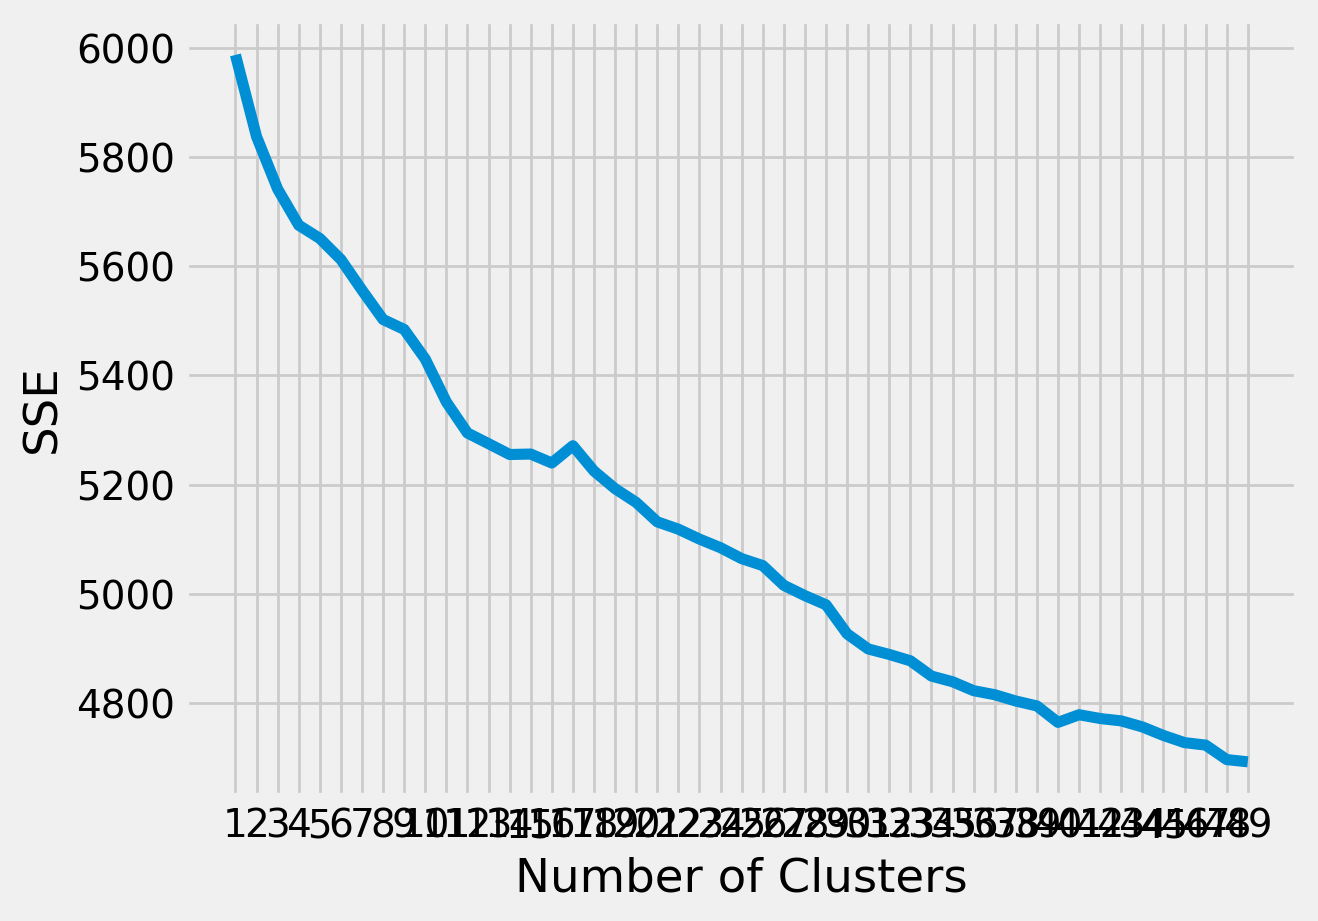

In [49]:
 plt.style.use("fivethirtyeight")
 plt.plot(range(1, 20), sse)
 plt.xticks(range(1, 20))
 plt.xlabel("Number of Clusters")
 plt.ylabel("SSE")
 plt.show()

In [47]:
range_n_clusters = [15]

For n_clusters = 15 The average silhouette_score is : 0.04794898237886976


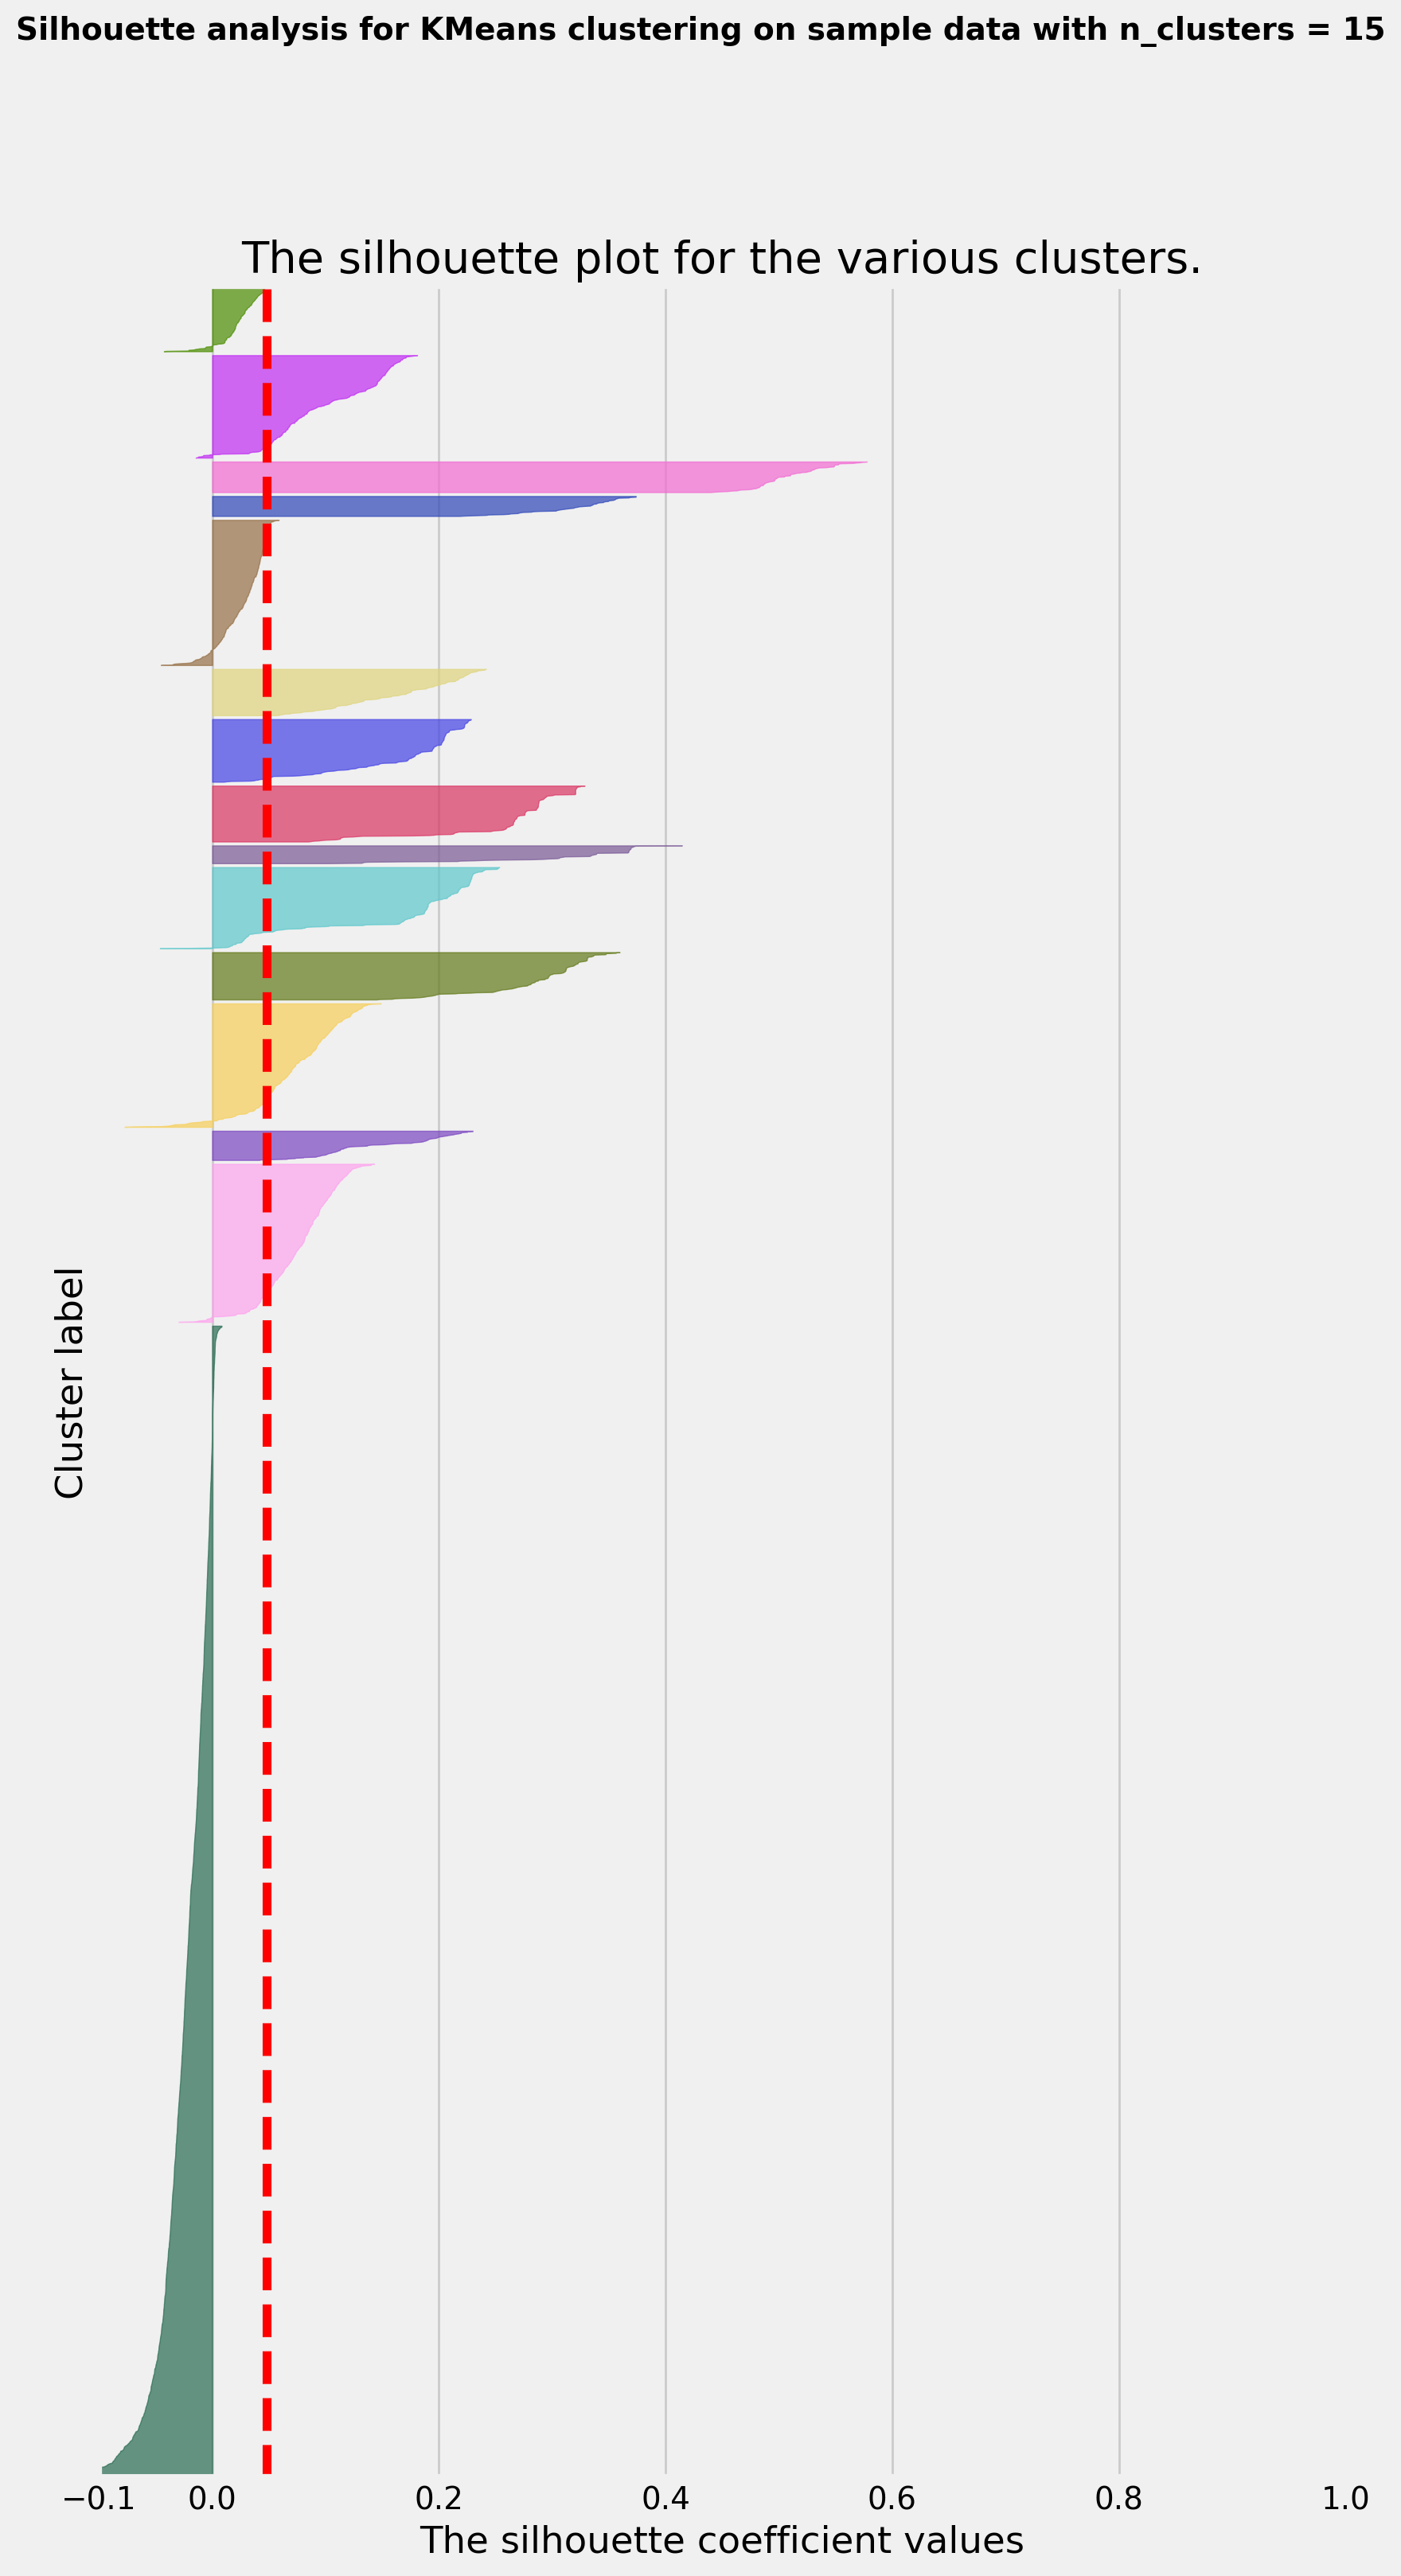

In [46]:
# modified from: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import random

for n_clusters in range_n_clusters:
    # Create a subplot
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(9, 17)

    # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
#     ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    ax1.set_ylim([0, 6000 + (n_clusters + 1) * 10])
    
    kmeans_kwargs = {
        "n_init": 20,
        "max_iter": 1000,
        "random_state": 54,
    }

    # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, **kmeans_kwargs)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        # select a random color for this cluster
        r = lambda: random.randint(0,255)
        color = '#%02X%02X%02X' % (r(),r(),r())
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
#         ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

### fit Kmeans

In [31]:
# #fit Kmeans with k clusters
# from sklearn.cluster import KMeans
# km = KMeans(n_clusters=50,n_init=30)
# km.fit(X)

#fit Kmeans with k clusters
from sklearn.cluster import KMeans

kmeans_kwargs = {
        "n_init": 20,
        "max_iter": 1000,
        "random_state": 54,
    }

km = KMeans(n_clusters=15, **kmeans_kwargs)
km.fit(X)

KMeans(max_iter=1000, n_clusters=15, n_init=20, random_state=54)

### labels are named with integers and stored in the `labels_` attribute

In [32]:
km.labels_

array([14,  0,  0, ...,  0,  0,  0], dtype=int32)

In [33]:
def countX(lst, x): 
    count = 0
    for ele in lst: 
        if (ele == x): 
            count = count + 1
    return count 

for i in range(0,15):
    # Driver Code 
    lst = km.labels_ 
    x = i
    print('{} has occurred {} times'.format(x, countX(lst, x))) 
     


0 has occurred 3228 times
1 has occurred 445 times
2 has occurred 83 times
3 has occurred 348 times
4 has occurred 134 times
5 has occurred 229 times
6 has occurred 51 times
7 has occurred 158 times
8 has occurred 177 times
9 has occurred 131 times
10 has occurred 409 times
11 has occurred 57 times
12 has occurred 87 times
13 has occurred 289 times
14 has occurred 278 times


### take a look at one of the cluster results

In [38]:
# You should look at all the clusters, but let's look at cluster "15" (I chose this arbitrarily; you should look at all of them)

for i in range(0,len(km.labels_)):
    if km.labels_[i] == 6:
        print(raw_data['product_description'][i])
#         print(corpus[i])
        print('**********')

Blue Bell Mint Cookies n Cream One Pint 473 mL
**********
Blue Bell Buttered Pecan One Pint 473 mL
**********
Blue Bell  Sherbert Orange One Quart Naturally Low Fat
**********
Blue Bell Sherbert Pineapple One Quart Naturally Low Fat
**********
Blue Bell Pecan Pralines n Cream One Pint 473 mL
**********
Blue Bell Chocolate Peanut Butter One Pint 473 mL
**********
Blue Bell Sherbet Rainbow Lime Orange  Strawberry One Pint 473 mL
**********
Blue Bell Pistachio Almond One Pint 473 mL
**********
Blue Bell No Sugar Added Country Vanilla One Pint 473 mL
**********
Blue Bell Banana Split One Pint 473 mL
**********
Blue Bell Italian Cream Cake One Pint 473 mL
**********
Blue Bell Coconut Fudge One Pint 473 mL
**********
Blue Bell Red Velvet Cake One Pint 473 mL
**********
Blue Bell Orange Swirl One Pint 473 mL
**********
Blue Bell Creole Cream Cheese One Pint 473 mL
**********
Blue Bell Magic Cookie Bar One Pint 473 mL
**********
Blue Bell Ice Cream Butter Crunch One Pint 473 mL and Half Pint S

In [36]:
from collections import Counter

print(Counter(" ".join(corpus).split()).most_common(300))
# print(corpus)
     

[('3', 806), ('salad', 781), ('0', 776), ('foods', 714), ('5', 713), ('1', 701), ('8', 677), ('cream', 641), ('ice', 641), ('2', 621), ('15', 588), ('12', 572), ('4', 483), ('gallon', 481), ('11596', 476), ('fresh', 470), ('25', 465), ('16', 464), ('7', 442), ('cheese', 438), ('6', 429), ('10', 418), ('butter', 394), ('frozen', 386), ('chocolate', 378), ('clear', 340), ('organic', 340), ('blue', 336), ('peanut', 323), ('gardenfresh', 309), ('milk', 303), ('ingredients', 300), ('bulk', 299), ('mix', 292), ('whole', 291), ('part', 276), ('9', 275), ('bell', 274), ('market', 263), ('carton', 261), ('best', 259), ('retail', 256), ('refrigerated', 255), ('cases', 251), ('potato', 245), ('salt', 242), ('number', 237), ('tubs', 237), ('red', 236), ('white', 236), ('name', 233), ('natural', 232), ('flavor', 222), ('formula', 222), ('box', 221), ('co', 214), ('package', 211), ('sugar', 207), ('smoked', 206), ('pint', 206), ('keep', 201), ('raw', 196), ('18', 190), ('bar', 189), ('green', 184), 